In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch
import torch.nn.functional as F
import pandas as pd
import torchvision
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchmetrics.classification import MulticlassConfusionMatrix, F1Score, MulticlassPrecision, MulticlassRecall, MulticlassPrecisionRecallCurve, MulticlassROC
from torch.optim import lr_scheduler
import torch.nn as nn
import torch
import pytorch_lightning as pl
from torch.utils.tensorboard import SummaryWriter
from matplotlib.backends.backend_agg import FigureCanvasAgg

import confinement_mode_classifier as cmc
import alt_models as am


In [72]:
signal_window = 320
num_workers = 6
signal_name = 'mc'
batch_size = 512
pl.seed_everything(42)
path=os.getcwd()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
shot_usage = pd.read_csv(f'{path}/data/shot_usage.csv')
shot_for_ris = shot_usage[shot_usage['used_for_alt']]
shot_numbers = shot_for_ris['shot']
shots_for_testing = shot_for_ris[shot_for_ris['used_as'] == 'test']['shot']
shots_for_validation = shot_for_ris[shot_for_ris['used_as'] == 'val']['shot']
shots_for_training = shot_for_ris[shot_for_ris['used_as'] == 'train']['shot']


Seed set to 42


In [4]:
from importlib import reload
reload(am)

<module 'alt_models' from '/compass/Shared/Users/bogdanov/vyzkumny_ukol/alt_models.py'>

In [76]:
shot_df300, test_df300, val_df300, train_df300 = am.split_df(path, shot_numbers,shots_for_training, shots_for_testing, shots_for_validation, use_ELMS=True, signal_name=signal_name, sampling_freq=300)
shot_df150, test_df150, val_df150, train_df150 = am.split_df(path, shot_numbers,shots_for_training, shots_for_testing, shots_for_validation, use_ELMS=True, signal_name=signal_name, sampling_freq=150)
shot_df30, test_df30, val_df30, train_df30 = am.split_df(path, shot_numbers,shots_for_training, shots_for_testing, shots_for_validation, use_ELMS=True, signal_name=signal_name, sampling_freq=30)

train_dataloader300 = am.get_dloader(train_df300, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

train_dataloader30 = am.get_dloader(train_df30, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

train_dataloader150 = am.get_dloader(train_df150, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

In [86]:
hyperparameters = {
'batch_size': 42,
'num_epochs': 12,
'optimizer': 'adanmw',
'criterion': 'cross_entropy',
'learning_rate_max': 0.01,
'scheduler': 'OneCycleLR',
'shots_for_testing': torch.tensor(shots_for_testing.values.tolist()),
'shots_for_validation': torch.tensor(shots_for_validation.values.tolist()),
'shots_for_training': torch.tensor(shots_for_training.values.tolist()),
'ris_option': 'RIS1',
'num_classes': 2,
'second_image': 'None',
'augmentation': "applied",
'random_seed': 42
}

metrics = {'Accuracy on test_dataset': 2, 
 'F1 metric on test_dataset':1, 
 'Precision on test_dataset':4, 
 'Recall on test_dataset':9}

all_hparams = {**hyperparameters, **metrics}

In [88]:
import json

# Assuming hyperparameters and metrics as before, but convert tensors to lists or another serializable format
for key in ['shots_for_testing', 'shots_for_validation', 'shots_for_training']:
    hyperparameters[key] = hyperparameters[key].tolist()  # Convert tensors to lists

all_hparams = {**hyperparameters, **metrics}

# Convert to JSON
json_str = json.dumps(all_hparams, indent=4)
with open('/compass/Shared/Users/bogdanov/vyzkumny_ukol/RIS1 preds for doubtful shots/hyperparameters_and_metrics.json', 'w') as f:
    f.write(json_str)

In [80]:
pd.DataFrame({**metrics}, index=[0]).to_csv(f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/RIS1 preds for doubtful shots/hparams.csv', sep='\t')

In [3]:

shot_df, test_df, val_df, train_df = am.split_df(path, shot_numbers, shots_for_testing, shots_for_validation, use_ELMS=True, signal_name=signal_name)


# Create dataloaders
train_dataloader = am.get_dloader(train_df, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

val_dataloader = am.get_dloader(val_df, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

test_dataloader = am.get_dloader(test_df, batch_size=batch_size, 
                            balance_data=False, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

In [8]:
model = am.select_model_architecture('InceptionTime', num_classes=3, window=320)
model.load_state_dict(torch.load(f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/runs/24-02-22, 18-31-57 InceptionTime_on_Mink_coil_320dpoints_16_epochs/model.pt'))
model.eval()

model.to(device)

torch.Size([512, 320, 4])

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=200, weight_decay=0.01)
exp_lr_scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=24) #!!!
learning_rates = []
for i in range(24):
    a = model(next(iter(train_dataloader))[signal_name].to(device).float())
    optimizer.step()
    exp_lr_scheduler.step()
    learning_rates.append(exp_lr_scheduler.get_last_lr())

In [1]:
import os
from pathlib import Path
import sys
# sys.path.append('/compass/Shared/Common/IT/projects/user-libraries/python/cdb_extras/stable/cdb_extras')
# import xarray_support as cdbxr   # načítání dat z databáze COMPASSu
from cdb_extras import xarray_support as cdbxr   # načítání dat z databáze COMPASSu
from pyCDB import client
import pandas as pd
import xrscipy.signal as dsp
import numpy as np
from tqdm import tqdm

In [2]:
cdb = client.CDBClient()
shot_usage = pd.read_csv(f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/data/shot_usage.csv')
shot_for_alt = shot_usage[shot_usage['used_for_alt']]
shot_numbers = shot_for_alt['shot']

In [3]:
mean_frequency_per_shot = pd.DataFrame(columns=['shot', 'mean_frequency [kHz]'])

for shot in tqdm(shot_numbers):
    signal = cdb.get_signal(f"f_ELM/SYNTHETIC_DIAGNOSTICS:{shot}:seidl_2023").data
    if signal is None or len(signal) == 0:
        print(f'No ELMs for shot {shot}')
    else:
        mean_frequency_per_shot = pd.concat([mean_frequency_per_shot, 
                                             pd.DataFrame({'shot': [shot], 'mean_frequency [kHz]': [np.mean(signal)]})])

 13%|█▎        | 7/53 [00:00<00:01, 33.56it/s]

No ELMs for shot 13182
No ELMs for shot 16532
No ELMs for shot 16989


 42%|████▏     | 22/53 [00:00<00:00, 42.63it/s]

No ELMs for shot 18127
No ELMs for shot 18128
No ELMs for shot 18130
No ELMs for shot 18133


 70%|██████▉   | 37/53 [00:00<00:00, 40.75it/s]

No ELMs for shot 18488
No ELMs for shot 18489
No ELMs for shot 18499
No ELMs for shot 19083
No ELMs for shot 19094


 89%|████████▊ | 47/53 [00:01<00:00, 41.56it/s]

No ELMs for shot 19244
No ELMs for shot 19379
No ELMs for shot 19915
No ELMs for shot 20009
No ELMs for shot 20143


 98%|█████████▊| 52/53 [00:01<00:00, 39.57it/s]


No ELMs for shot 20144
No ELMs for shot 20146


TypeError: len() of unsized object

Text(0, 0.5, 'Num of shots')

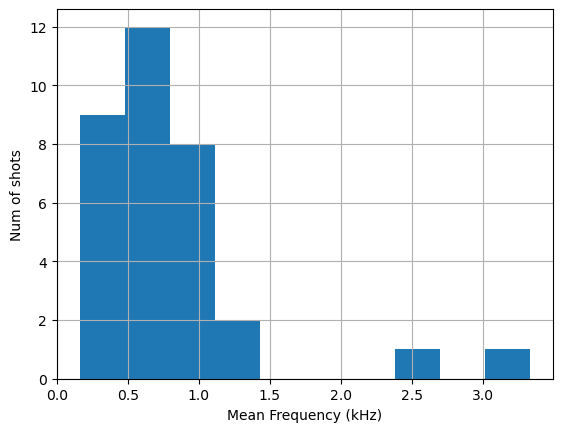

In [8]:
import matplotlib.pyplot as plt
mean_frequency_per_shot['mean_frequency [kHz]'].hist(bins=10, )
plt.xlabel('Mean Frequency (kHz)') # Setting the label for the x-axis
plt.ylabel('Num of shots') # Setting the label for the y-axis

In [6]:
mean_frequency_per_shot['mean_frequency [kHz]'].std()

0.63815732360972

In [11]:
zza
signal = cdb.get_signal(f"f_ELM/SYNTHETIC_DIAGNOSTICS:{shot}:{variant}")